In [393]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
import os
from copy import deepcopy
from statsmodels.tsa import exponential_smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import OneHotEncoder
from fbprophet import Prophet

from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

import warnings
import pmdarima as pm
import yfinance as yf
plt.style.use('seaborn-whitegrid')
%matplotlib inline
warnings.filterwarnings('ignore')

В качестве данных будут взяты дневные(цены закрытия) ао Сбер, диапозон дат: 2021-02-05 : 2021-12-20

In [394]:
# data_y =  yf.download("SBERP.ME", start="2021-02-05", end="2021-12-20")

In [395]:
# data_y.head()

# Экспоненциальное сглаживание, модель Хольта-Винтерса

In [396]:
os.chdir('C:\\Users\\ruden\\Desktop')  #workspace

In [397]:
data = pd.read_csv('SBER.ME.csv',usecols=[0,4,6]) 

In [398]:
data.head()

,Date,Close,Volume
0,2021-02-05,271.269989,68413800
1,2021-02-08,275.390015,47749570
2,2021-02-09,267.920013,87050990
3,2021-02-10,266.489990,58721920
4,2021-02-11,265.140015,35293270


In [399]:
data.Date = pd.to_datetime(data.Date)

In [400]:
data['Day of week'] = data.Date.dt.day_of_week

In [480]:
ohe = OneHotEncoder(sparse=False) #ohe для дней недели

In [402]:
days_ = pd.DataFrame(
    ohe.fit_transform(data['Day of week'].to_numpy().reshape(-1, 1)),
    index=data.index,
    columns=['Monday', 'Tuesday', 'Wednesday', 'Thuesday', 'Friday'],
    
)
# pd.get_dummies(data['Day of week'])

In [403]:
data = pd.concat([data, days_], axis=1)

In [404]:
data.drop(['Day of week'], inplace=True, axis=1)

In [405]:
data.head()

,Date,Close,Volume,Monday,Tuesday,Wednesday,Thuesday,Friday
0,2021-02-05,271.269989,68413800,0.0,0.0,0.0,0.0,1.0
1,2021-02-08,275.390015,47749570,1.0,0.0,0.0,0.0,0.0
2,2021-02-09,267.920013,87050990,0.0,1.0,0.0,0.0,0.0
3,2021-02-10,266.489990,58721920,0.0,0.0,1.0,0.0,0.0
4,2021-02-11,265.140015,35293270,0.0,0.0,0.0,1.0,0.0


In [406]:
work_days = ['Monday', 'Tuesday', 'Wednesday', 'Thuesday', 'Friday']
avg_volume = []
for d in work_days:
    v = data.Volume[data[f'{d}'] == 1].mean()
    avg_volume.append(v)

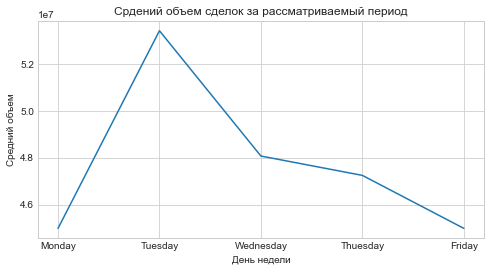

In [481]:
plt.figure(figsize=(8,4)) # срдений объем сделок в течение недели за рассматриваемый период
plt.plot(work_days, avg_volume)
plt.title('Срдений объем сделок за рассматриваемый период')
plt.xlabel(u'День недели')
plt.ylabel(u'Средний объем');

In [482]:
mov_avg = data.Close.rolling(window=10).mean() # тренд с помощью MA и 2хMA
mov_avg_x2 = mov_avg.rolling(window=5).mean()

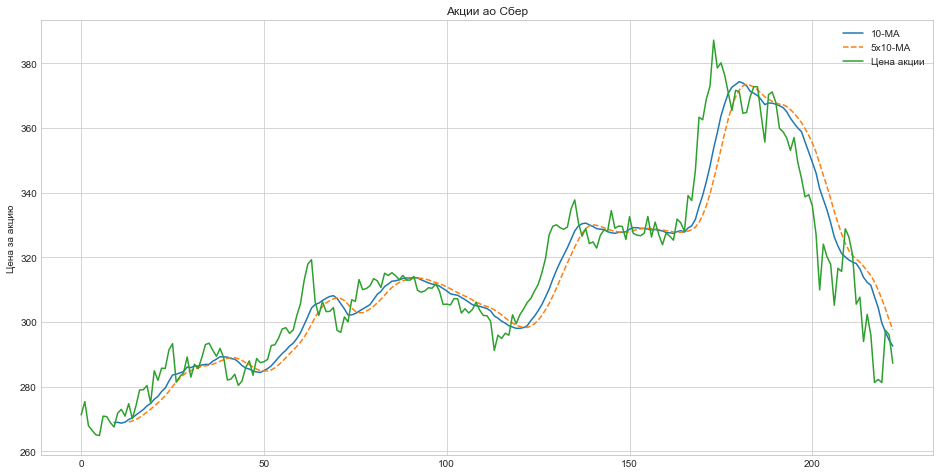

In [409]:
plt.figure(figsize=(16,8))
plt.plot(mov_avg, label='10-MA')
plt.plot(mov_avg_x2, '--', label='5x10-MA')
plt.plot(data.Close, label='Цена акции')
plt.legend(loc='best')
plt.ylabel(u'Цена за акцию')
plt.title(u'Акции ао Сбер');

In [410]:
detrended = data.Close[10:] - mov_avg

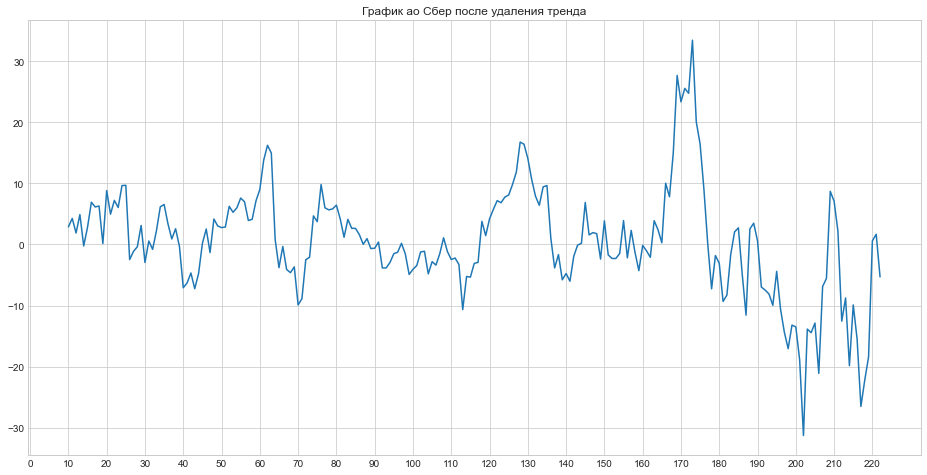

In [483]:
plt.figure(figsize=(16, 8)) #данные очищенные от тренда
plt.title('График ао Сбер после удаления тренда')
plt.xticks(ticks=[x for x in range(0,data.shape[0],10)])
plt.plot(detrended);

In [412]:
print(f"Критерий Стьюдента: p={stats.ttest_1samp(detrended.dropna(), 0)[1]}, не отвергает гипотезу не смещенности отстатков" )
print(f"Критерий Дики-Фуллера: p={sm.tsa.stattools.adfuller(detrended.dropna())[1]}, не отвергает гипотезу не стационарности ряда")

Критерий Стьюдента: p=0.4505407721744459, не отвергает гипотезу не смещенности отстатков
Критерий Дики-Фуллера: p=0.13569518982289497, не отвергает гипотезу не стационарности ряда


Видим, что в остатках хранится информациz, которую, возможно, можно получить введя некоторую недельную или месячную зависимость

In [413]:
horizon_ = 5
train_lenght = len(data) - horizon_
train_data = data.iloc[0: train_lenght]
test_data = data.iloc[train_lenght:]

In [414]:
model_ETS = ExponentialSmoothing(train_data.Close, seasonal_periods=5, trend='additive', damped_trend=True).fit()

In [415]:
fitted_ = model_ETS.predict(0, len(train_data) + horizon_ - 1)

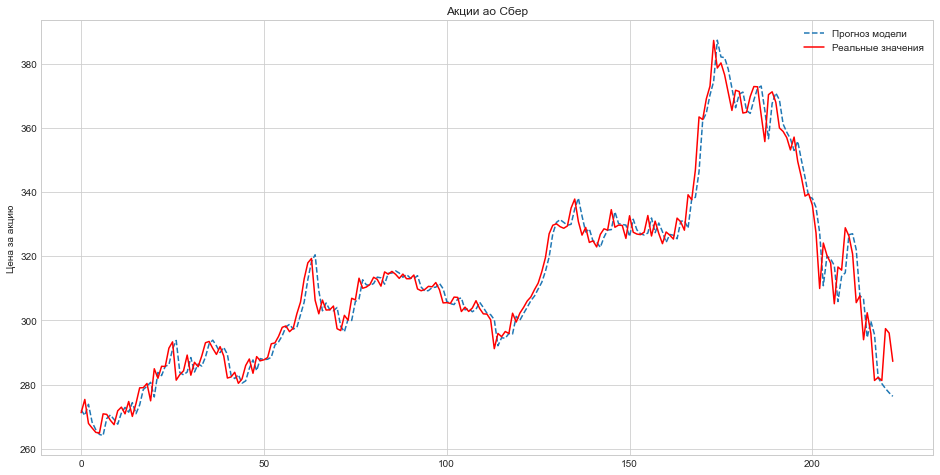

In [416]:
plt.figure(figsize=(16,8))
plt.plot(fitted_, '--', label='Прогноз модели')
plt.plot(data.Close, 'r', label='Реальные значения')
plt.legend(loc='best')
plt.ylabel(u'Цена за акцию')
plt.title(u'Акции ао Сбер');

In [417]:
exp_smoothing_err = [mean_absolute_percentage_error(test_data.Close, fitted_[-horizon_:]), \
                    mean_absolute_error(test_data.Close, fitted_[-horizon_:]), \
                    mean_squared_error(test_data.Close, fitted_[-horizon_:])]
exp_smoothing_forecast = [*fitted_[-horizon_:]]

# Prophet

In [418]:
data_prophet = train_data.iloc[:,0:2].copy()
data_prophet.columns = ['ds', 'y']

In [419]:
data_prophet.head()

,ds,y
0,2021-02-05,271.269989
1,2021-02-08,275.390015
2,2021-02-09,267.920013
3,2021-02-10,266.489990
4,2021-02-11,265.140015


In [420]:
model_prophet = Prophet(n_changepoints=25,
                        weekly_seasonality=True,
                        yearly_seasonality=False,
                        daily_seasonality=False,
                        seasonality_mode='additive'
                       )
model_prophet.fit(data_prophet)

In [421]:
prophet_forecast_df = model_prophet.make_future_dataframe(periods=horizon_)

In [422]:
prophet_forecast = model_prophet.predict(prophet_forecast_df)

In [423]:
prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
prophet_forecast.iloc[-horizon_:, 0] = pd.to_datetime(test_data.Date)

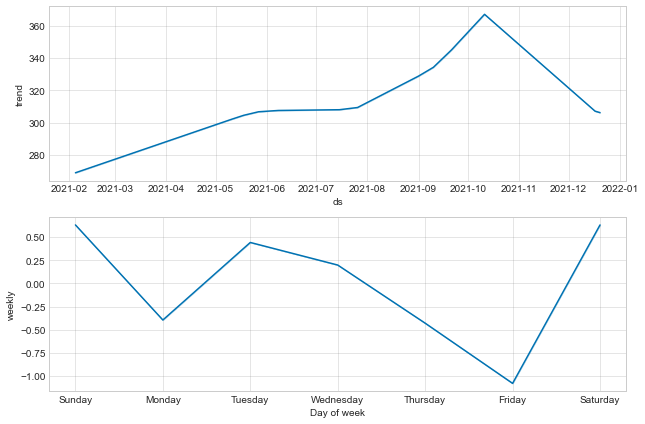

In [424]:
model_prophet.plot_components(prophet_forecast);

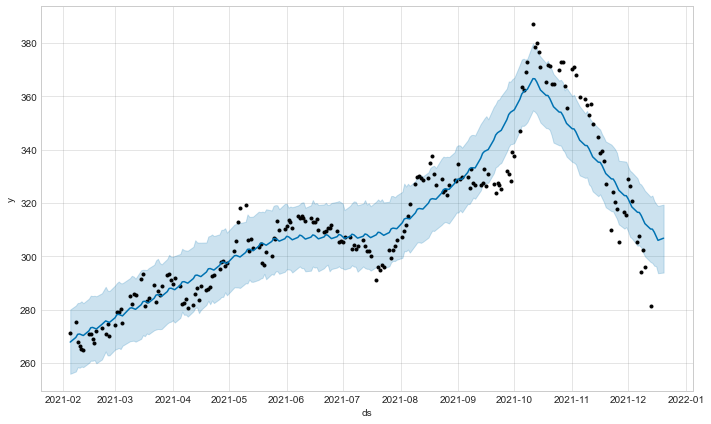

In [425]:
model_prophet.plot(prophet_forecast);

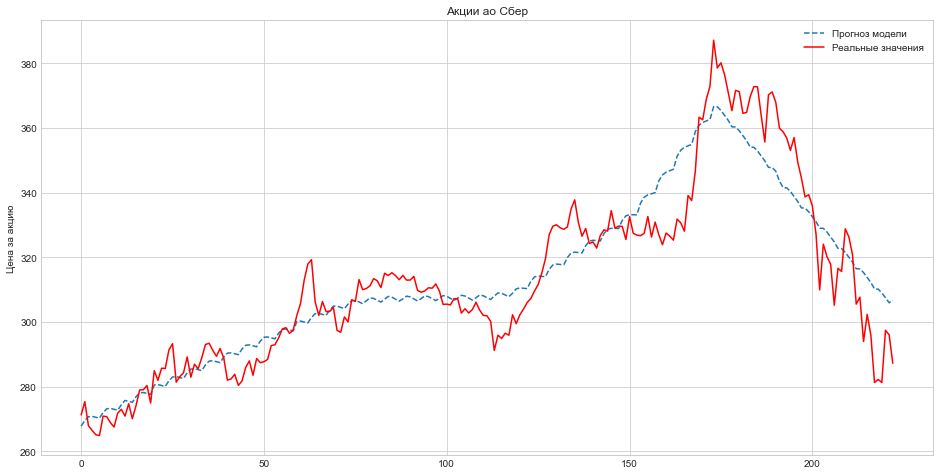

In [426]:
plt.figure(figsize=(16,8))
plt.plot(prophet_forecast.yhat, '--', label='Прогноз модели')
plt.plot(data.Close, 'r', label='Реальные значения')
plt.legend(loc='best')
plt.ylabel(u'Цена за акцию')
plt.title(u'Акции ао Сбер');

In [427]:
prophet_err = [mean_absolute_percentage_error(test_data.Close, prophet_forecast.yhat[-horizon_:]), \
                    mean_absolute_error(test_data.Close, prophet_forecast.yhat[-horizon_:]), \
                    mean_squared_error(test_data.Close, prophet_forecast.yhat[-horizon_:])]
prophet_forecast = [*prophet_forecast.yhat[-horizon_:]]

# Linear Regression

In [428]:
data_LR = data.copy()
data_LR.head()

,Date,Close,Volume,Monday,Tuesday,Wednesday,Thuesday,Friday
0,2021-02-05,271.269989,68413800,0.0,0.0,0.0,0.0,1.0
1,2021-02-08,275.390015,47749570,1.0,0.0,0.0,0.0,0.0
2,2021-02-09,267.920013,87050990,0.0,1.0,0.0,0.0,0.0
3,2021-02-10,266.489990,58721920,0.0,0.0,1.0,0.0,0.0
4,2021-02-11,265.140015,35293270,0.0,0.0,0.0,1.0,0.0


In [429]:
data_LR.drop('Volume', axis=1, inplace=True)

In [430]:
for i in range(1, 3):
    data_LR[f'ylag {i}'] = data_LR.Close.shift(i)

In [431]:
data_LR.dropna(inplace=True)

In [484]:
dp = DeterministicProcess(
    index=data_LR.index,  
    constant=True,       
    order=4,            
    drop=True,           
)
#тренд кусочно-линейный, пробовал разные порядки, со значение 4 оказался лучший вариант
X = dp.in_sample()

In [433]:
y = data_LR.iloc[:len(data) - horizon_,:].Close

In [434]:
X = pd.concat([X, data_LR.iloc[:,2:]], sort=False, axis=1)
X

,const,trend,trend_squared,trend_cubed,trend**4,Monday,Tuesday,Wednesday,Thuesday,Friday,ylag 1,ylag 2
2,1.0,1.0,1.0,1.0,1.000000e+00,0.0,1.0,0.0,0.0,0.0,275.390015,271.269989
3,1.0,2.0,4.0,8.0,1.600000e+01,0.0,0.0,1.0,0.0,0.0,267.920013,275.390015
4,1.0,3.0,9.0,27.0,8.100000e+01,0.0,0.0,0.0,1.0,0.0,266.489990,267.920013
5,1.0,4.0,16.0,64.0,2.560000e+02,0.0,0.0,0.0,0.0,1.0,265.140015,266.489990
6,1.0,5.0,25.0,125.0,6.250000e+02,1.0,0.0,0.0,0.0,0.0,264.899994,265.140015
...,...,...,...,...,...,...,...,...,...,...,...,...
218,1.0,217.0,47089.0,10218313.0,2.217374e+09,0.0,1.0,0.0,0.0,0.0,281.309998,295.940002
219,1.0,218.0,47524.0,10360232.0,2.258531e+09,0.0,0.0,1.0,0.0,0.0,282.250000,281.309998
220,1.0,219.0,47961.0,10503459.0,2.300258e+09,0.0,0.0,0.0,1.0,0.0,281.299988,282.250000
221,1.0,220.0,48400.0,10648000.0,2.342560e+09,0.0,0.0,0.0,0.0,1.0,297.450012,281.299988


In [435]:
model_LR = LinearRegression(fit_intercept=False, n_jobs=1000)
model_LR.fit(X.iloc[:len(data) - horizon_,:], y)

LinearRegression(fit_intercept=False, n_jobs=1000)

In [436]:
y_pred = pd.Series(model_LR.predict(X), index=X.index)

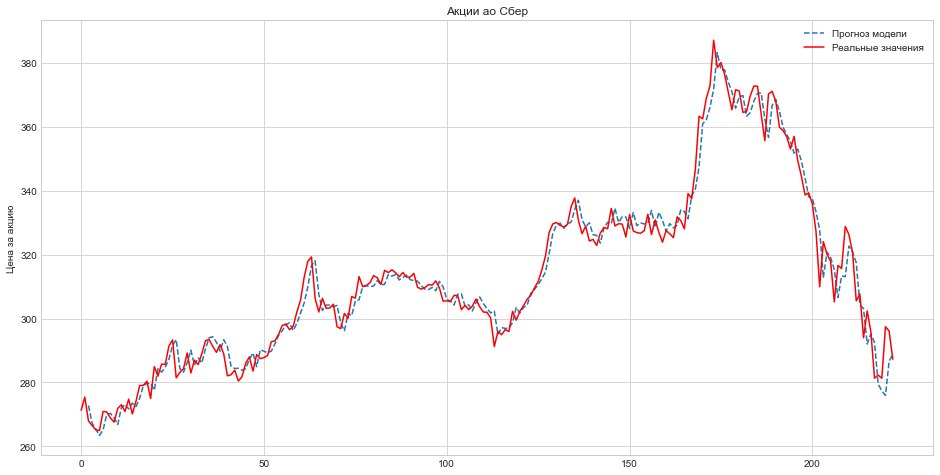

In [437]:
plt.figure(figsize=(16,8))
plt.plot(y_pred, '--', label='Прогноз модели')
plt.plot(data.Close, 'r', label='Реальные значения')
plt.legend(loc='best')
plt.ylabel(u'Цена за акцию')
plt.title(u'Акции ао Сбер');

In [438]:
LR_err = [mean_absolute_percentage_error(test_data.Close, y_pred[-horizon_:]), \
                    mean_absolute_error(test_data.Close, y_pred[-horizon_:]), \
                    mean_squared_error(test_data.Close, y_pred[-horizon_:])]
LR_forecast = [*y_pred[-horizon_:]]

Добавление lags приводит к переобучению модели

# Xgboost

In [439]:
data_xgb = data.copy()

In [440]:
#переобучение ?
# for i in range(1, 3):
#     data_xgb[f'ylag {i}'] = data_xgb.Close.shift(i)

In [441]:
dp = DeterministicProcess(
    index=data_LR.index,  
    constant=True,       
    order=1,            
    drop=True,           
)

X = dp.in_sample()

In [442]:
data_xgb.dropna(inplace=True)

In [443]:
y = data_LR.iloc[:len(data) - horizon_,:].Close
X = pd.concat([X, data_xgb.iloc[:,2:]], sort=False, axis=1)

In [444]:
model_XGB = XGBRegressor()
model_XGB.fit(X.iloc[:len(data) - horizon_,:], y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [445]:
y_pred_xgb = pd.Series(model_XGB.predict(X), index=X.index)

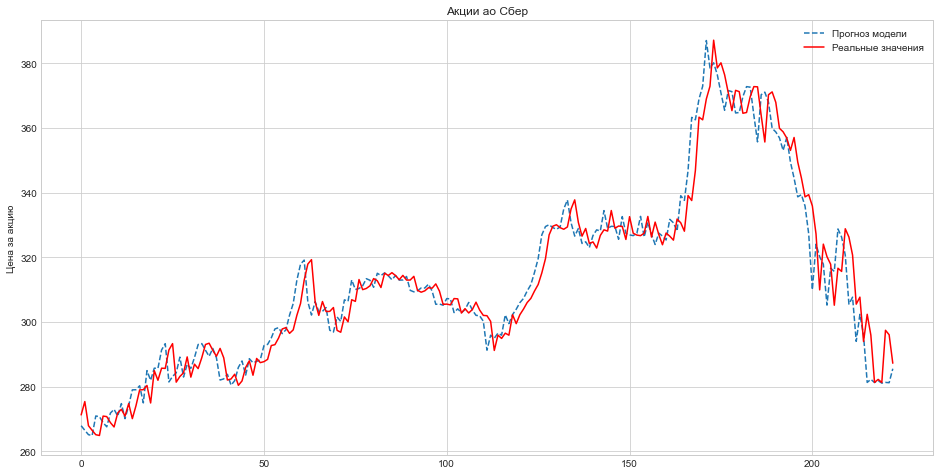

In [446]:
plt.figure(figsize=(16,8))
plt.plot(y_pred_xgb, '--', label='Прогноз модели')
plt.plot(data.Close, 'r', label='Реальные значения')
plt.legend(loc='best')
plt.ylabel(u'Цена за акцию')
plt.title(u'Акции ао Сбер');

In [447]:
xgb_err = [mean_absolute_percentage_error(test_data.Close, y_pred_xgb[-horizon_:]), \
                    mean_absolute_error(test_data.Close, y_pred_xgb[-horizon_:]), \
                    mean_squared_error(test_data.Close, y_pred_xgb[-horizon_:])]
xgb_forecast = [*y_pred_xgb[-horizon_:]]

# Гибридные модели

С помощью обычной линейной регрессии получаю тренд, после чего обучаю xgboost на остатках <br>
    y_pred = y_LR + y_XGB

In [448]:
data_hybrid = data.copy()

In [449]:
dp = DeterministicProcess(
    index=data_hybrid.index,  
    constant=True,       
    order=1,            
    drop=True,           
)

X = dp.in_sample()

In [450]:
y = data_hybrid.iloc[:len(data) - horizon_,:].Close

In [451]:
model_p1 = LinearRegression()
model_p1.fit(X.iloc[:len(data) - horizon_,:], y)
p1 = model_p1.predict(X.iloc[:len(data) - horizon_,:])

In [452]:
model_p2 = XGBRegressor()

In [453]:
model_p2.fit(X.iloc[:len(data) - horizon_,:], y - p1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [454]:
y_pred_hybrid = model_p1.predict(X) + model_p2.predict(X)

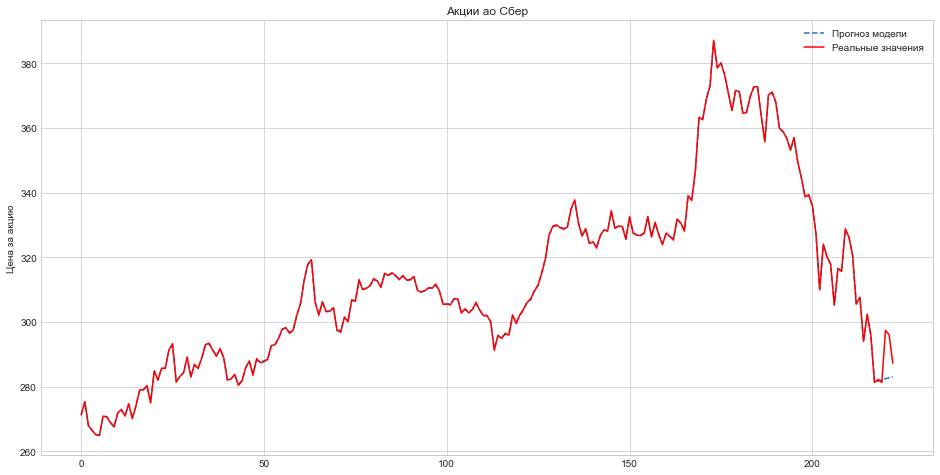

In [455]:
plt.figure(figsize=(16,8))
plt.plot(y_pred_hybrid, '--', label='Прогноз модели')
plt.plot(data.Close, 'r', label='Реальные значения')
plt.legend(loc='best')
plt.ylabel(u'Цена за акцию')
plt.title(u'Акции ао Сбер');

In [456]:
hybrid_err = [mean_absolute_percentage_error(test_data.Close, y_pred_hybrid[-horizon_:]), \
                    mean_absolute_error(test_data.Close, y_pred_hybrid[-horizon_:]), \
                    mean_squared_error(test_data.Close, y_pred_hybrid[-horizon_:])]
hybrid_forecast = [*y_pred_hybrid[-horizon_:]]

# Модели класса ARMA

In [457]:
data_arma = data.copy()

In [458]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller((data_arma.Close))[1])
print('Гипотеза нестацонарности ряда не отвергнута')

Критерий Дики-Фуллера: p=0.279910
Гипотеза нестацонарности ряда не отвергнута


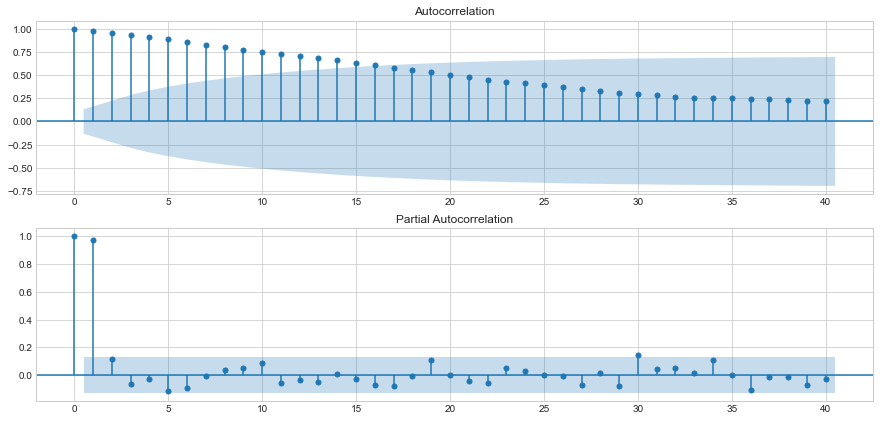

In [459]:
plt.figure(figsize=(15,7))
plt.subplot(211)
plot_acf(data_arma.Close, lags=40, ax=plt.gca())
plt.subplot(212)
plot_pacf(data_arma.Close, method='ywmle', lags=40, ax=plt.gca())
plt.show()

Используем преобразование Бокса-Кокса

In [460]:
# data_arma.Close, lmbda = stats.boxcox(data_arma.Close)
# print(lmbda)

In [461]:
# print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_arma.Close)[1])

In [462]:
data_arma_diff = data_arma.Close.diff(periods=1).dropna()

In [463]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_arma_diff)[1])
print('Получаем стационарный ряд, в нашей будущей модели d=1')

Критерий Дики-Фуллера: p=0.000000
Получаем стационарный ряд, в нашей будущей модели d=1


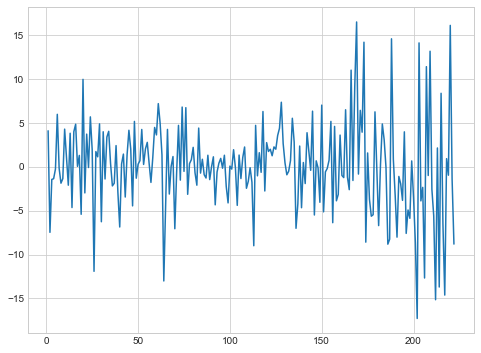

In [464]:
plt.figure(figsize=(8,6))
data_arma_diff.plot();

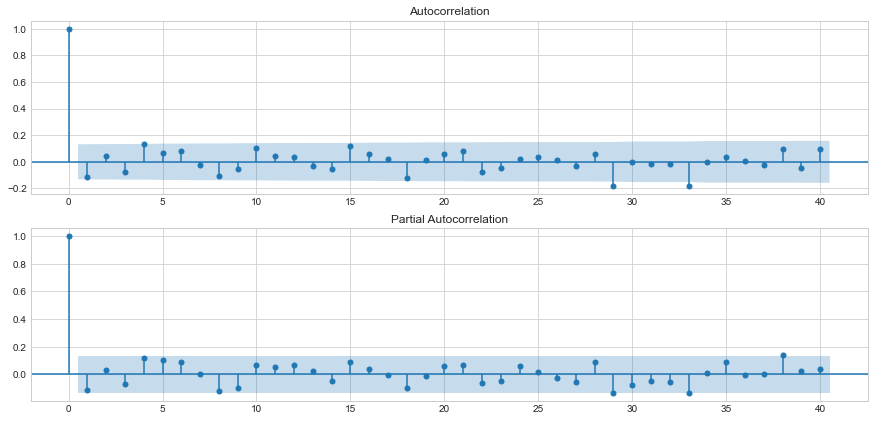

In [465]:
plt.figure(figsize=(15,7))
plt.subplot(211)
plot_acf(data_arma_diff, lags=40, ax=plt.gca())
plt.subplot(212)
plot_pacf(data_arma_diff, method='ywmle', lags=40, ax=plt.gca())
plt.show()

По графикам ACP и PACF видим что нет зависимости в данных, то есть лучший прогноз модели это последнее значение трейн сета. Случайное блуждание

In [466]:
horizon_ = 5
train_lenght = len(data_arma) - horizon_
train_data = data_arma.iloc[0: train_lenght]
test_data = data_arma.iloc[train_lenght:]

In [467]:
model_arma = pm.auto_arima(train_data.Close, start_p=0, d=1,start_q=0,max_p=5, max_d=5, max_q=5,
                           start_P=0, D=0, start_Q=0, max_P=5, max_D=5, max_Q=5, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1330.071, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1329.328, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1329.627, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1328.089, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1328.784, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.144 seconds


In [468]:
model_arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  218
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -663.044
Date:                Sun, 02 Jan 2022   AIC                           1328.089
Time:                        00:37:29   BIC                           1331.469
Sample:                             0   HQIC                          1329.454
                                - 218                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        26.3938      1.906     13.844      0.000      22.657      30.130
===================================================================================
Ljung-Box (L1) (Q):                   2.66   Jarque-Bera (JB):                21.84
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               2.99   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

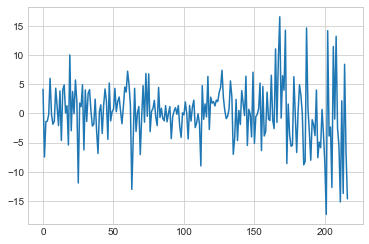

In [469]:
plt.plot(model_arma.resid()[1:]); #график остатков модели

In [470]:
print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(model_arma.resid(), 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(model_arma.resid())[1])

Критерий Стьюдента: p=0.318974
Критерий Дики-Фуллера: p=0.000000


С помощью критерия Стьюдента произведено тестирование гипотезы не смещенности ошибки, которую не отвергли - ошибка не смещана, с помощью критерия Дики-Фулера произведена проверка гипотезы нестационарности, которая была отвергнута, т.е. ряд стационарный <br>
Данные тесты показывают то что наша модель оптимальна, в остатках больше нет никакой полезной информации для прогноза

In [471]:
y_pred_arma = pd.DataFrame(model_arma.predict(n_periods=horizon_), index=test_data.index, columns=['ARMA'])

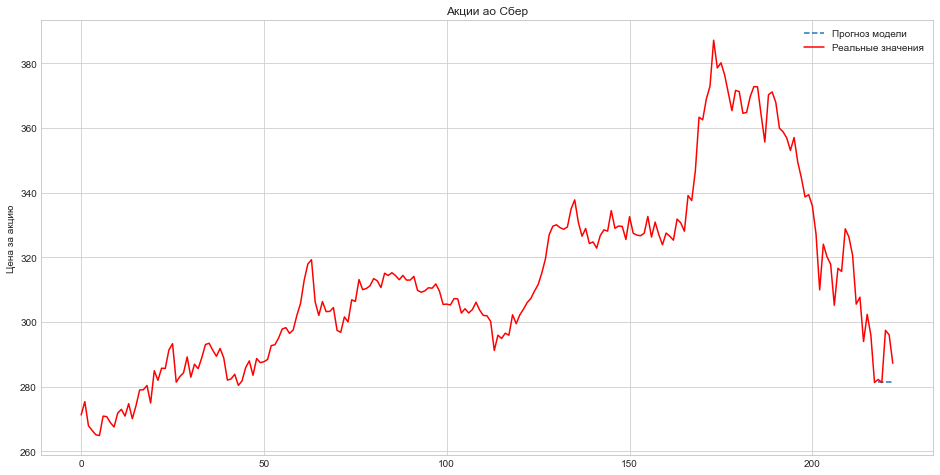

In [472]:
plt.figure(figsize=(16,8))
plt.plot(y_pred_arma, '--', label='Прогноз модели')
plt.plot(data_arma.Close, 'r', label='Реальные значения')
plt.legend(loc='best')
plt.ylabel(u'Цена за акцию')
plt.title(u'Акции ао Сбер');

In [473]:
arma_err = [mean_absolute_percentage_error(test_data.Close, y_pred_arma), \
                    mean_absolute_error(test_data.Close, y_pred_arma), \
                    mean_squared_error(test_data.Close, y_pred_arma)]
arma_forecast = [*y_pred_arma.ARMA]

# Прогноз

In [474]:
errors_ = pd.DataFrame({'Эксп.сгл' : exp_smoothing_err,
                       'Prophet' : prophet_err,
                       'LR' : LR_err,
                       'XGB' : xgb_err,
                       'ARMA' : arma_err,
                       'Hybrid' : hybrid_err}, index=['MAPE', 'MAE', 'MSE'])

In [475]:
forecst = pd.DataFrame({'Эксп.сгл' : exp_smoothing_forecast,
                       'Prophet' : prophet_forecast,
                       'LR' : LR_forecast,
                       'XGB' : xgb_forecast,
                       'ARMA' : arma_forecast,
                       'Hybrid' : hybrid_forecast})

In [476]:
forecst['AVG'] = forecst.mean(axis=1)

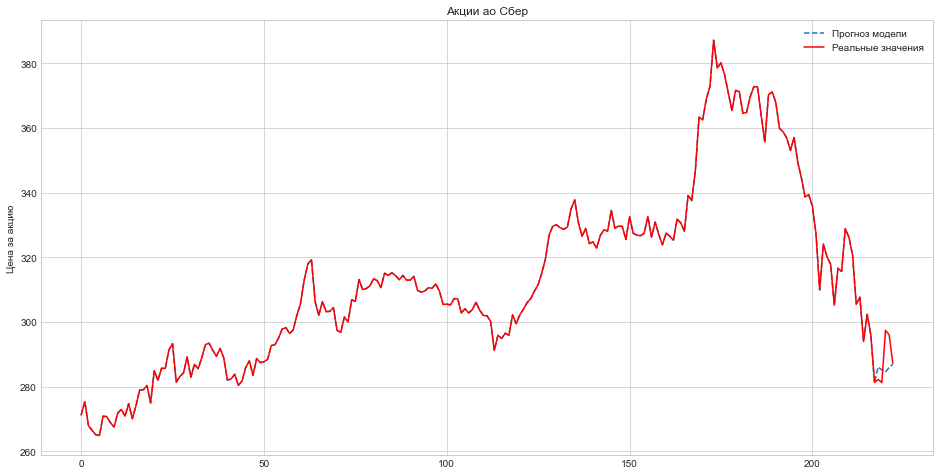

In [477]:
cum_ans = pd.concat([train_data.Close, forecst['AVG']], axis=0)
cum_ans.index = data.index
plt.figure(figsize=(16,8))
plt.plot(cum_ans, '--', label='Прогноз модели')
plt.plot(data.Close, 'r', label='Реальные значения')
plt.legend(loc='best')
plt.ylabel(u'Цена за акцию')
plt.title(u'Акции ао Сбер');

In [478]:
print(f'MAPE : {mean_absolute_percentage_error(test_data.Close, forecst.AVG)}')
print(f'MAE  : {mean_absolute_error(test_data.Close, forecst.AVG)}')
print(f'MSE  : {mean_squared_error(test_data.Close, forecst.AVG)**0.5}')

MAPE : 0.02123075115867998
MAE  : 6.217214852525274
MSE  : 7.742889109744065


In [479]:
forecst.AVG

0    286.122921
1    285.199033
2    284.550726
3    285.906187
4    286.988989
Name: AVG, dtype: float64